<a href="https://colab.research.google.com/github/alanchan30/NeuralNetworkAnalyzation/blob/main/Neural_Network_Analyzation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [ ]:
from sklearn.datasets import fetch_openml

# load the MNIST dataset (the original version with 28x28 images)
mnist = fetch_openml(name='mnist_784', version=1, as_frame=False)

In [ ]:
# get the data and labels
X, y = mnist.data, mnist.target

# converts array with string labels into integers
y = y.astype(int)

# turn it into a pandas dataframe
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [ ]:
# split the data into only 5% of what it actually is to reduce time
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 42)

In [ ]:
# train and test splitting of data
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
# applying standard scaling to get optimized result, makes all numbers in same range
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# neural network with 11 nodes in hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(11), max_iter=500)
# train the model
mlp.fit(X_train,y_train)
# predict the model
mlp_pred = mlp.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# see how the model performed, how good y_test did compared to our mlp_pred
print(classification_report(y_test, mlp_pred))
print(confusion_matrix(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1343
           1       0.95      0.97      0.96      1600
           2       0.89      0.91      0.90      1380
           3       0.91      0.89      0.90      1433
           4       0.91      0.93      0.92      1295
           5       0.90      0.89      0.89      1273
           6       0.92      0.95      0.94      1396
           7       0.92      0.92      0.92      1503
           8       0.91      0.88      0.89      1357
           9       0.91      0.90      0.90      1420

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000

[[1277    0   14    2    6    2   26    4   11    1]
 [   0 1545    8   11    1    7    4    6   15    3]
 [  10   18 1252   18   10   10   21   22   18    1]
 [   7   15   34 1279    5   35    2   21   19   16]
 [   3    3    3    2 1199   

In [ ]:
def normalize_activations(activations):
    # Calculate the minimum and maximum values for each node
    min_vals = activations.min(axis=0)  # Minimum for each column (node)
    max_vals = activations.max(axis=0)  # Maximum for each column (node)

    # Apply min-max normalization
    normalized_activations = (activations - min_vals) / (max_vals - min_vals)

    return normalized_activations

# Use Leaky ReLU instead of ReLU if saturation is suspected
def get_hidden_layer_activations(model, X):
    hidden_layer_input = np.dot(X, model.coefs_[0]) + model.intercepts_[0]
    hidden_layer_activations = np.where(hidden_layer_input > 0, hidden_layer_input, hidden_layer_input * 0.01)
    return hidden_layer_activations

# Extract the the hidden layer activations for the test set
hidden_layer_activations = get_hidden_layer_activations(mlp, X_test)

# Normalize the hidden layer activations
normalized_hidden_layer_activations = normalize_activations(hidden_layer_activations)

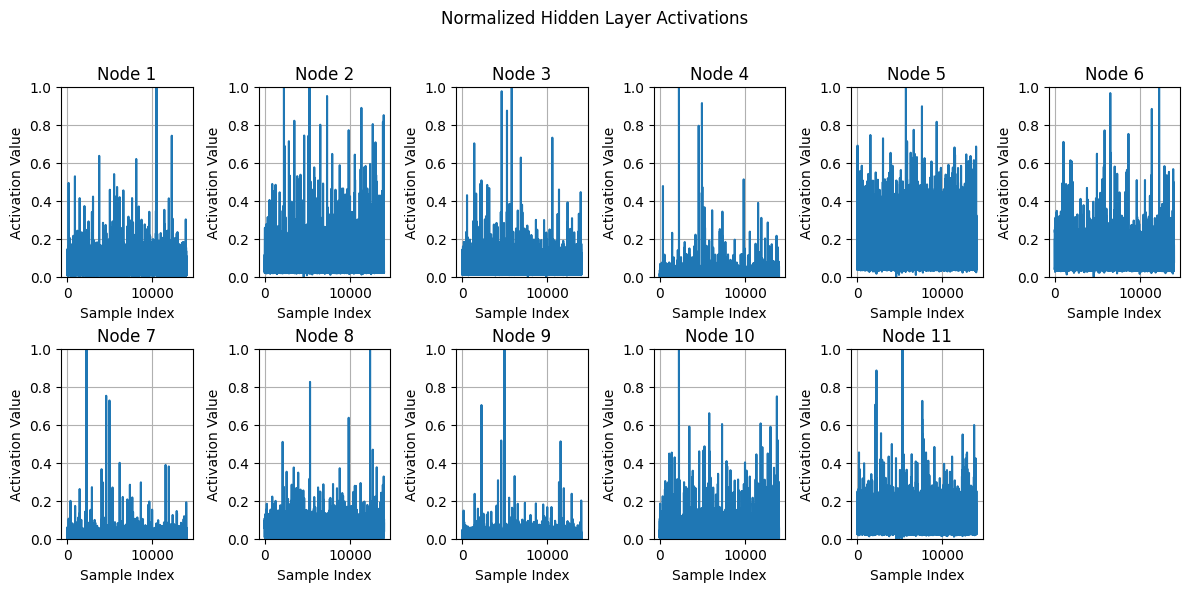

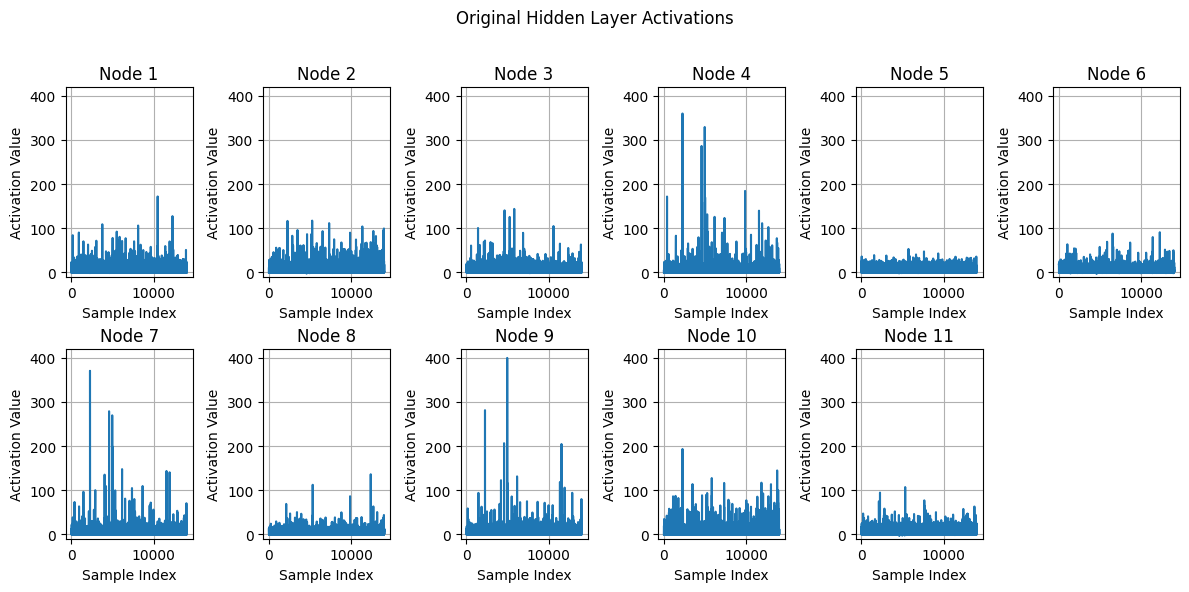

In [ ]:
# Plot the normalized activations of the hidden layer (11 nodes)
plt.figure(figsize=(12, 6))
for i in range(normalized_hidden_layer_activations.shape[1]):  # Loop over each node in the hidden layer
  plt.subplot(2, 6, i+1)  # Create a subplot for each node
  plt.plot(normalized_hidden_layer_activations[:, i])  # Plot the activation for the node
  plt.title(f'Node {i+1}')  # Set the title of the subplot to the node number
  plt.xlabel('Sample Index')
  plt.ylabel('Activation Value')
  plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
  plt.grid(True)  # Add a grid to the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping text
plt.suptitle('Normalized Hidden Layer Activations') # Big title for plots
plt.subplots_adjust(top=0.85)  # Adjust the title position
plt.show()  # Display the plot

print(" ") # Provide a space between plots

# Plot the original activations of the hidden layer (11 nodes)
plt.figure(figsize=(12, 6))
for i in range(hidden_layer_activations.shape[1]):  # Loop over each node in the hidden layer
  plt.subplot(2, 6, i+1)  # Create a subplot for each node
  plt.plot(hidden_layer_activations[:, i])  # Plot the activation for the node
  plt.title(f'Node {i+1}')  # Set the title of the subplot to the node number
  plt.xlabel('Sample Index')
  plt.ylabel('Activation Value')
  plt.ylim(-10, 420)  # Set the y-axis limit to [-10, 410]
  plt.grid(True)  # Add a grid to the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping text
plt.suptitle('Original Hidden Layer Activations') # Big title for plots
plt.subplots_adjust(top=0.85)  # Adjust the title position
plt.show()  # Display the plot

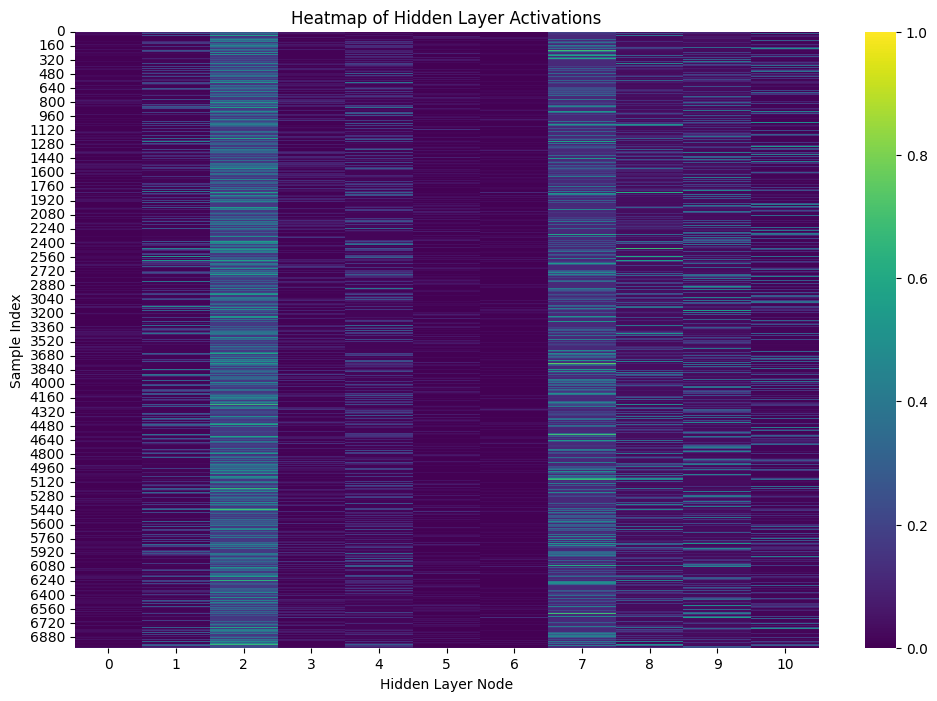

In [ ]:
# Convert activations to a DataFrame for better visualization (optional but useful)
activation_df = pd.DataFrame(hidden_layer_activations)

# Create a min/max scaler to normalize the data values
scaler = MinMaxScaler()
activation_df_normalized = scaler.fit_transform(activation_df)
# activation_df_normalized = activation_df_normalized[:250]  # Limiting the normalized data values to just the first 250 sample indexes

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(activation_df_normalized, cmap='viridis', cbar=True)  # Customize cmap as needed
plt.xlabel("Hidden Layer Node")
plt.ylabel("Sample Index")
plt.title("Heatmap of Hidden Layer Activations")
plt.show()